# Preparing HECKTOR data
Volumes/crops containing cancer are extracted.

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import pickle
import seaborn as sns

In [3]:
# Defining data paths:
MODE = "train_data"

if MODE == "test_data":
    imagePath = './hecktor2022/hecktor2022_testing/imagesTs_resampled/'
    maskPath = './hecktor2022/hecktor2022_testing/labelsTs_resampled/'
    clinical_df = pd.read_csv("./hecktor2022/hecktor2022_testing/hecktor2022_clinical_info_testing.csv")
    endpoint = pd.read_csv("./hecktor2022/hecktor2022_testing/hecktor2022_endpoint_testing.csv")
    save_path = './Data/test_data/'
elif MODE == "train_data":
    imagePath = './hecktor2022/hecktor2022_training/imagesTr_resampled/'
    maskPath = './hecktor2022/hecktor2022_training/labelsTr_resampled/'
    clinical_df = pd.read_csv("./hecktor2022/hecktor2022_training/hecktor2022_patient_info_training.csv")
    endpoint = pd.read_csv("./hecktor2022/hecktor2022_training/hecktor2022_patient_endpoint_training.csv")
    save_path = './Data/train_data/'

## Raw data quick review

### Tabular data

In [6]:
clinical_df.head()

,PatientID,CenterID,Gender,Age,Tobacco,Alcohol,Performance_status,"HPV status (0=-, 1=+)",Surgery,Chemotherapy
0,CHUM-001,1,M,82,NaN,NaN,NaN,NaN,NaN,1
1,CHUM-002,1,M,73,NaN,NaN,NaN,NaN,NaN,1
2,CHUM-006,1,M,65,NaN,NaN,NaN,NaN,NaN,1
3,CHUM-007,1,F,70,NaN,NaN,NaN,NaN,NaN,0
4,CHUM-008,1,F,67,NaN,NaN,NaN,NaN,NaN,1


In [7]:
endpoint.head()

,PatientID,Relapse,RFS
0,CHUM-001,0,1704
1,CHUM-002,1,439
2,CHUM-006,0,1186
3,CHUM-007,0,1702
4,CHUM-008,0,1499


Text(0.5, 0.98, 'Visualization of variables')

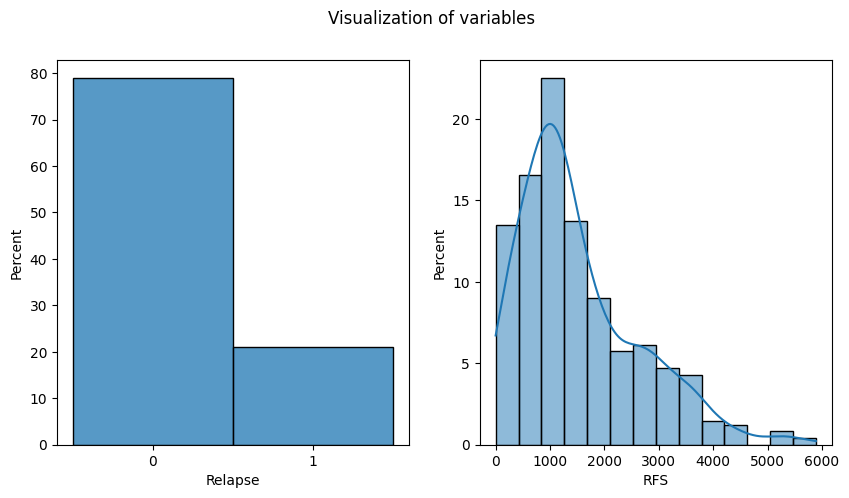

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Distribution of censored and non-censored examples.
bins = [-0.5, 0.5, 1.5]
sns.histplot(endpoint,
             x="Relapse",
             kde=False,
             bins=bins,
             stat="percent",
             ax=axs[0])
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'])

# Distribution of RFS.
sns.histplot(endpoint,
             x="RFS",
             kde=True,
             bins=14,
             stat="percent",
             ax=axs[1])

plt.suptitle("Visualization of variables")

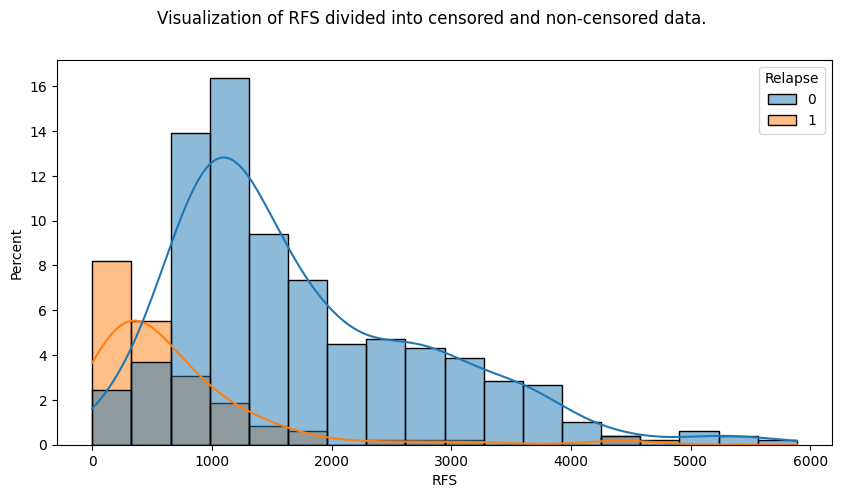

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Distribution of RFS.
sns.histplot(endpoint,
             x="RFS",
             kde=True,
             bins=18,
             stat="percent",
             ax=ax,
             hue="Relapse")

plt.suptitle("Visualization of RFS divided into censored and non-censored data.")

plt.show()

### Examples visualization

In [70]:
# Extracting patients IDs:
ids = clinical_df['PatientID'].to_list()

In [71]:
ids[:5]

['CHUM-001', 'CHUM-002', 'CHUM-006', 'CHUM-007', 'CHUM-008']

In [72]:
def load_images(IDs):
    print("Loading images ...")
    data = {}
    for id in tqdm(IDs):
        labelPath = os.path.join(maskPath, id + '.nii.gz')
        ctPath = os.path.join(imagePath, id + '__CT.nii.gz')
        petPath = os.path.join(imagePath, id + '__PT.nii.gz')
        mask = sitk.ReadImage(labelPath)
        CT = sitk.ReadImage(ctPath)
        PET = sitk.ReadImage(petPath)
        mask = sitk.GetArrayFromImage(mask)
        CT = sitk.GetArrayFromImage(CT)
        PET = sitk.GetArrayFromImage(PET)
        data[id] = (CT, PET, mask)
    return data

In [73]:
exemplary_data = load_images(['CHUM-001'])

Loading images ...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


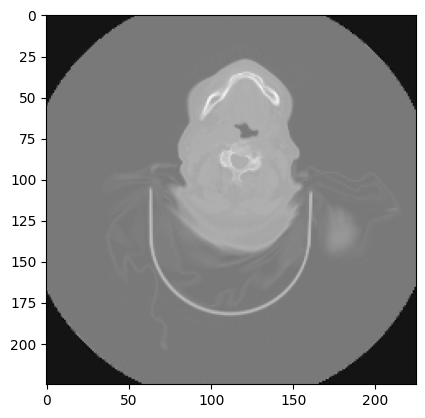

In [75]:
args = {
    "data": exemplary_data,
    "patient_ID": 'CHUM-001',
    "method": "CT",
    "slice": 50,
    "apply_mask": False
}

def visualize_raw_data(data, patient_ID, method, slice, apply_mask):
    assert method in ("CT", "PET")
    
    plt.set_cmap('gray')
    CT, PET, mask = data[patient_ID]
    img = CT if method == "CT" else PET
    img = img[slice]
    if apply_mask:
        img = img*mask[slice]
    plt.imshow(img)

visualize_raw_data(**args)

## Extracting Nodules
Based on mask a center of a bounding box (cbbox) is computed. Then volume around cbbox is extracted with a specified margin.

In [17]:
def load_image(id, maskPath, imagePath):
    maskPath = os.path.join(maskPath, id + '.nii.gz')
    ctPath = os.path.join(imagePath, id + '__CT.nii.gz')
    petPath = os.path.join(imagePath, id + '__PT.nii.gz')
    mask = sitk.ReadImage(maskPath)
    CT = sitk.ReadImage(ctPath)
    PET = sitk.ReadImage(petPath)
    mask = sitk.GetArrayFromImage(mask)
    CT = sitk.GetArrayFromImage(CT)
    PET = sitk.GetArrayFromImage(PET)
    return CT, PET, mask


def extract_nodule(patient_id, margin, maskPath, imagePath):
    CT, PET, mask = load_image(patient_id, maskPath, imagePath)
    segmentation = np.where(mask != 0)
    # Mask contains 0, 1, 2 labels. Where 0 -> background, 1 -> GTVp (primary Gross Tumor Volume), 2 -> GTVn (Nodal Gross Tumor Volume).
    # Computed segmentation variable is a Tuple, containing arrays of non-zero indices in each of three dimensions.
    bbox = 0, 0, 0, 0
    if len(segmentation) != 0:
        z_min = int(np.min(segmentation[0]))
        z_max = int(np.max(segmentation[0]))
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[2]))
        y_max = int(np.max(segmentation[2]))
        # bbox is a list of extreme indices in each of dimensions.
        bbox = [(z_min, z_max), (x_min, x_max), (y_min, y_max)]
        # Center of bbox is computed by averaging extreme indexes in each of dimensions.
        cbbox = [round((bbox[i][0]+bbox[i][1])/2) for i in range(3)]
        slices = (
                slice(max(cbbox[0]-margin, 0), min(cbbox[0]+margin, CT.shape[0]-1)),
                slice(max(cbbox[1]-margin, 0), min(cbbox[1]+margin, CT.shape[1]-1)),
                slice(max(cbbox[2]-margin, 0) , min(cbbox[2]+margin, CT.shape[2]-1))
             )
        #Cropping a nodule volume from res_data by defined slices tupple.
        crop_CT = torch.Tensor(CT[slices])
        crop_PET = torch.Tensor(PET[slices])
        crop_mask = torch.Tensor(mask[slices])
    return crop_CT, crop_PET, crop_mask

A cell below perform extraction of nodules (both from CT and PET) for specified patients.

In [ ]:
Path(f"{save_path}/crops_CT").mkdir(parents=True, exist_ok=True)
Path(f"{save_path}/crops_PET").mkdir(parents=True, exist_ok=True)
Path(f"{save_path}/crops_mask").mkdir(parents=True, exist_ok=True)


args = {
    "IDs": ['CHUM-001', 'CHUM-002', 'CHUM-006', 'CHUM-007', 'CHUM-008'], # List of patients to extract.
    "margin": 15, # adjust margin around center of bbox.
    "save_path": save_path,
    "maskPath": maskPath, 
    "imagePath": imagePath
}


def prepare_data(IDs, margin, save_path, maskPath, imagePath):
    print("Extracting nodules ...")
    for patient_id in tqdm(IDs):
        try:
            crop_CT, crop_PET, crop_mask = extract_nodule(patient_id, margin, maskPath, imagePath)
            torch.save(crop_CT.clone(), f"{save_path}/crops_CT/{patient_id}.pt")
            torch.save(crop_PET.clone(), f"{save_path}/crops_PET/{patient_id}.pt")
            torch.save(crop_mask.clone(), f"{save_path}/crops_mask/{patient_id}.pt")
        except Exception as e:
            print(f"Something wrong for patient: {patient_id}")
            print(e)
    return "Done"

In [25]:
prepare_data(**args)

Extracting nodules ...


100%|████████████████████████████████████████████████████| 524/524 [1:21:50<00:00,  9.37s/it]


'Done'

## Visualization of archieved crops

In [45]:
def visualize_crop(ID, slice_, path):
    plt.set_cmap('gray')
    CT = torch.load(path+"crops_CT"+f"/{ID}.pt").numpy()
    PET = torch.load(path+"crops_PET"+f"/{ID}.pt").numpy()
    fig, axs = plt.subplots(1,3, figsize=(10,5), layout="constrained")
    axs[0].imshow(CT[slice_])
    axs[0].set_title("CT")
    
    axs[1].imshow(PET[slice_])
    axs[1].set_title("PET")

    merged_img = (CT*PET)**3
    axs[2].imshow(merged_img[slice_])
    axs[2].set_title("Merged CT&PET")
 
    print(CT.shape)

(100, 100, 100)


<Figure size 640x480 with 0 Axes>

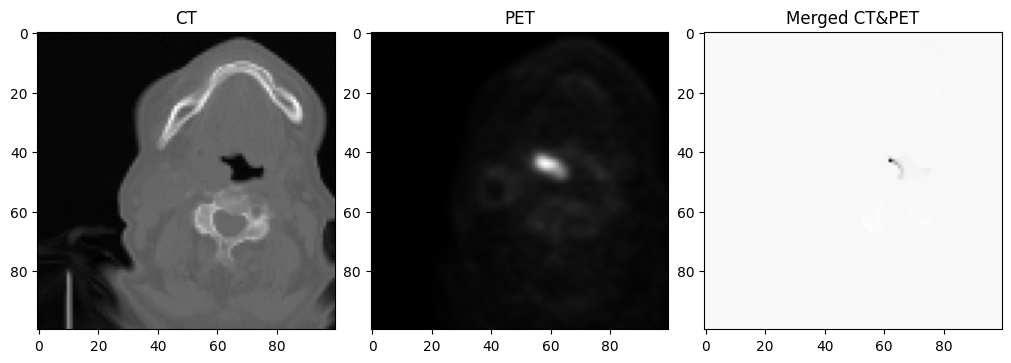

In [76]:
visualize_crop(ID='CHUM-001', slice_=50, path="./Data/train_data/")

## Splitting data into 5CV folds.
Search for best hyperparameters will be done with 5-fold Cross-Validation.

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
folds = skf.split(X=endpoint["PatientID"], y=endpoint["Relapse"])

In [24]:
for i, (train_indices, val_indices) in enumerate(folds):
    with open(save_path+f"train_fold_{i+1}.pkl", 'wb') as file:
        pickle.dump(list(train_indices), file)
    with open(save_path+f"val_fold_{i+1}.pkl", 'wb') as file:
        pickle.dump(list(val_indices), file)

## Indices for full training.
Full training, is done on all examples from train set.

In [5]:
with open(save_path+f"train_fold_all.pkl", 'wb') as file:
    train_indices=list(range(len(endpoint["PatientID"])))
    pickle.dump(train_indices, file)